# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output


# Color

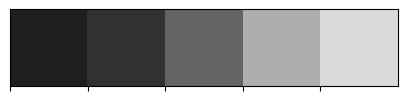

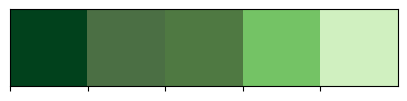

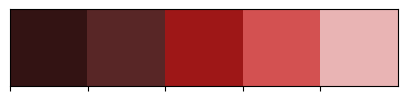

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [3]:
labels = ['Fake','Real']

In [5]:
labels = ['Fake', 'Real']
image_size = 150

def load_data(base_path, subset, labels, image_size=150):
    X, y = [], []
    for label in labels:
        folderPath = os.path.join(base_path, subset, label)
        for file in tqdm(os.listdir(folderPath), desc=f"Loading {subset}-{label}"):
            img = cv2.imread(os.path.join(folderPath, file))
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

base_path = r'C:\Users\kotav\Downloads\archive (3)\data'

X_train, y_train = load_data(base_path, 'train', labels, image_size)
X_val, y_val = load_data(base_path, 'validation', labels, image_size)
X_test, y_test = load_data(base_path, 'test', labels, image_size)


Loading test-Real: 100%|██████████| 1200/1200 [00:11<00:00, 102.62it/s]


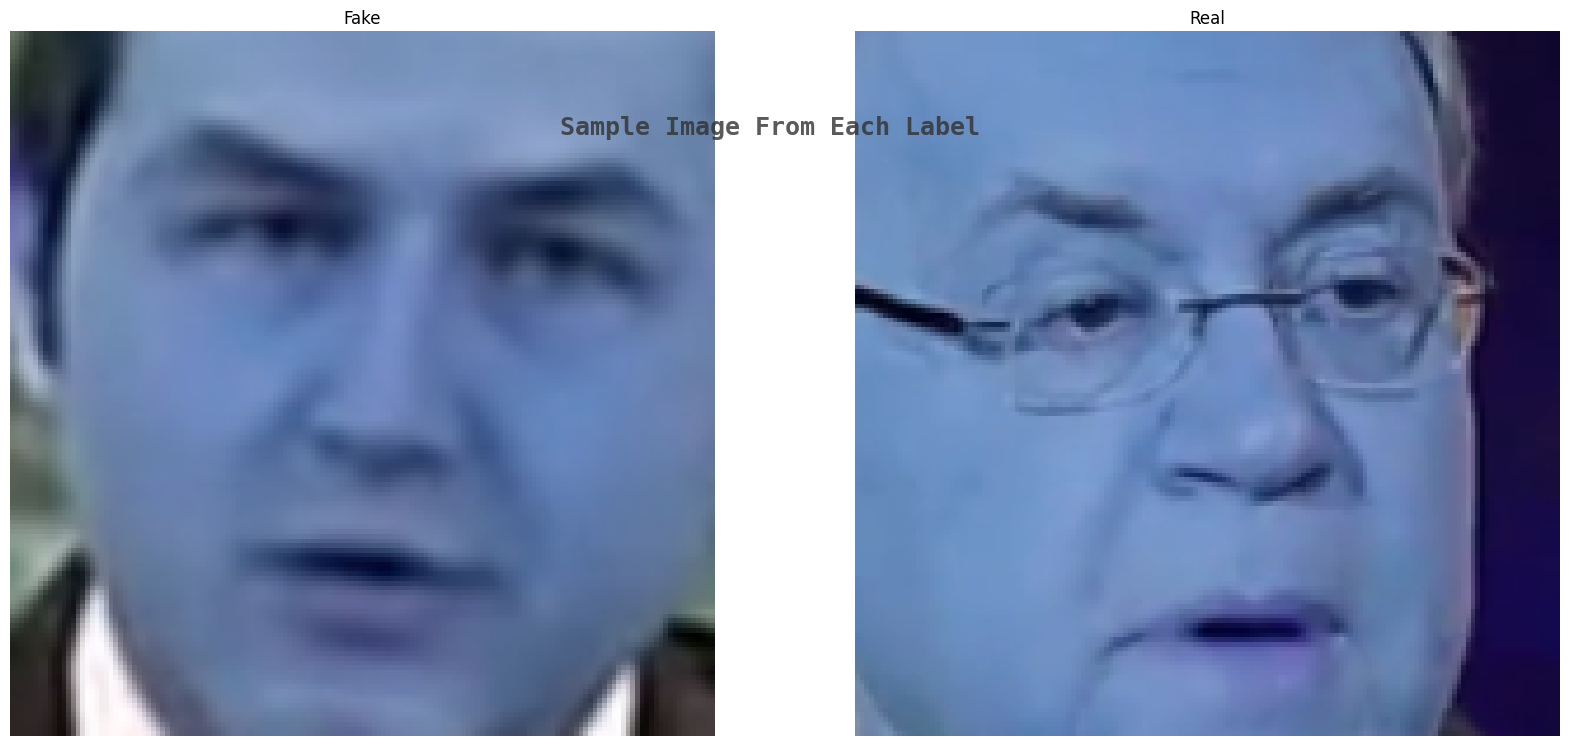

In [6]:
k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(11633, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (11633, 150, 150, 3) (11633,)
Validation set: (2400, 150, 150, 3) (2400,)
Test set: (2400, 150, 150, 3) (2400,)


In [10]:
# Convert training labels to categorical
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)

# Convert validation labels to categorical
y_val_new = [labels.index(i) for i in y_val]
y_val = tf.keras.utils.to_categorical(y_val_new)

# Convert test labels to categorical
y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new)


---

# Transfer Learning

In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [12]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
# checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1,
    callbacks=[checkpoint, reduce_lr, tensorboard]
)

# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_cb = ModelCheckpoint("my_model.keras", save_best_only=True)

# model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint_cb])
# model.save("my_model.keras")


Epoch 1/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8526 - loss: 0.3238
Epoch 1: val_accuracy improved from -inf to 0.90917, saving model to effnet.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 1194s 3s/step - accuracy: 0.8528 - loss: 0.3234 - val_accuracy: 0.9092 - val_loss: 0.2555 - learning_rate: 0.0010
Epoch 2/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9712 - loss: 0.0792
Epoch 2: val_accuracy improved from 0.90917 to 0.91083, saving model to effnet.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 1167s 3s/step - accuracy: 0.9712 - loss: 0.0792 - val_accuracy: 0.9108 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 3/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9766 - loss: 0.0526
Epoch 3: val_accuracy did not improve from 0.91083
364/364 ━━━━━━━━━━━━━━━━━━━━ 1163s 3s/step - accuracy: 0.9766 - loss: 0.0526 - val_accuracy: 0.9021 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 4/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9854 - loss: 0.0353
Epoch 4: val_accu

In [ ]:
model.save('/content/saved_model.keras')

In [ ]:
model.save('/content/save_model.h5')

In [17]:
from warnings import filterwarnings

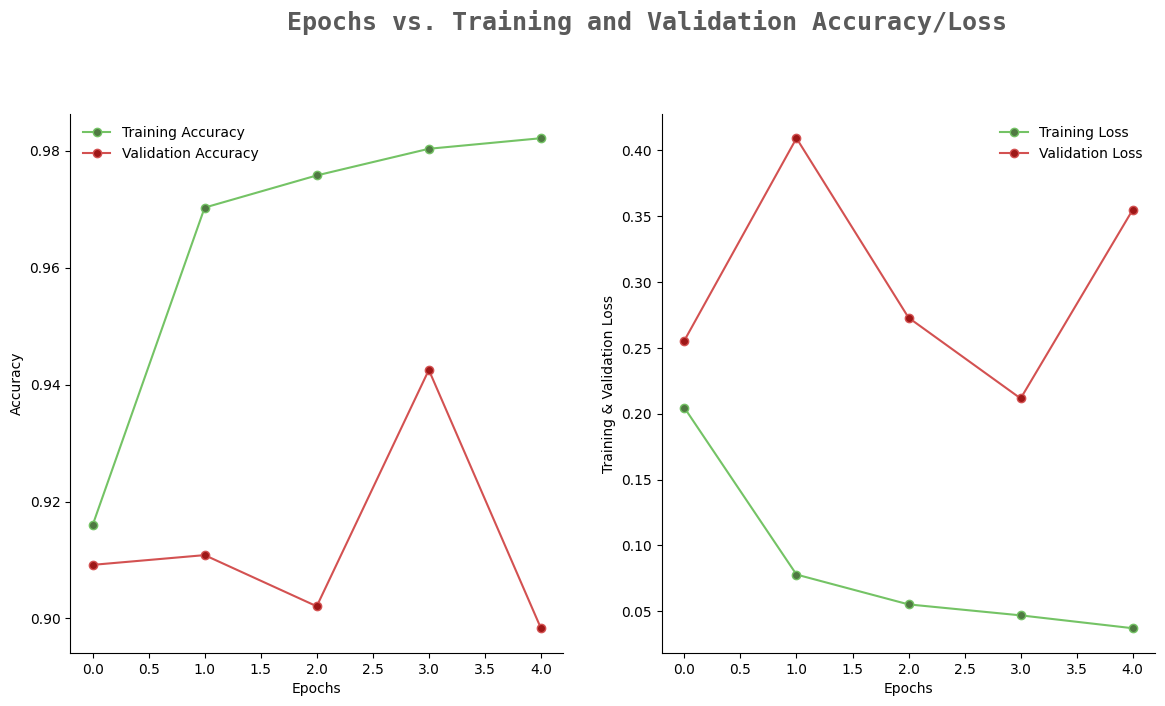

In [18]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()



---

# Prediction

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step


---

# Evaluation

In [20]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1200
           1       0.81      0.97      0.88      1200

    accuracy                           0.87      2400
   macro avg       0.89      0.87      0.87      2400
weighted avg       0.89      0.87      0.87      2400



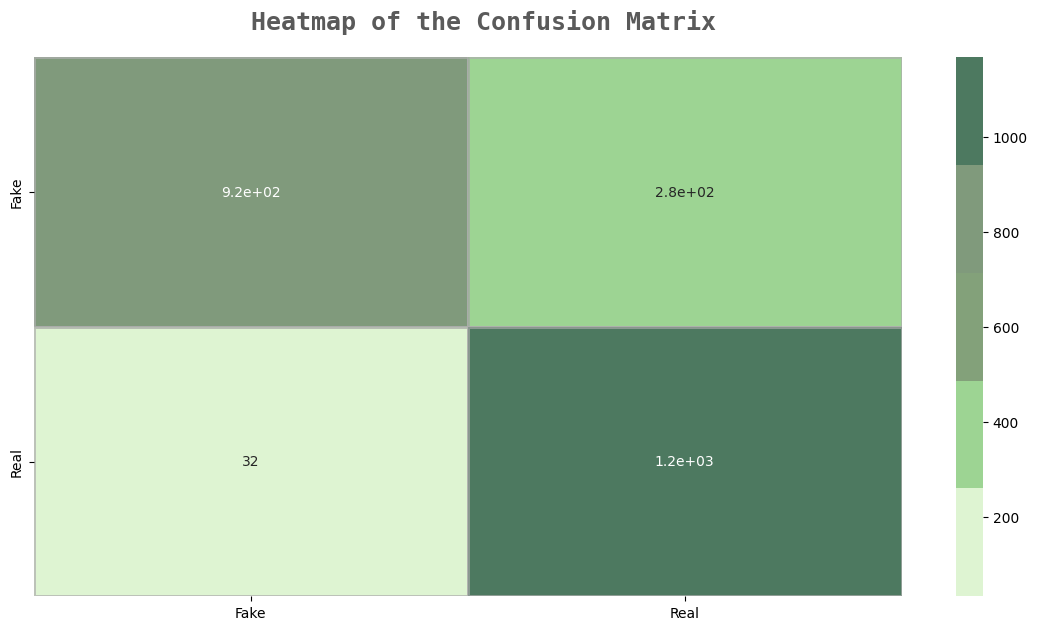

In [21]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()